In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fairaudit import Auditor, Metric
from fairaudit.groups import get_intersections

# COMPAS data

In this notebook, we will apply the certification and flagging tools to the COMPAS dataset.

In [32]:
df_deciles = pd.read_csv('../data/compas-scores-two-years.csv')
keep_columns = ["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
                "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", 
                "c_jail_in", "c_jail_out"]

df_deciles = df_deciles[keep_columns]

# filter out rows that we do not have labels/scores for
row_filter = (df_deciles["days_b_screening_arrest"] <= 30) & (df_deciles["days_b_screening_arrest"] >= -30)
row_filter &= (df_deciles["is_recid"] != -1) & (df_deciles["c_charge_degree"] != "O") 
row_filter &= df_deciles["score_text"] != "NA"
df_deciles = df_deciles[row_filter]

df_deciles

group_feats = ['race', 'age_cat', 'sex'] # groups we will consider throughout

In [33]:
# get racial features
unique_races, race_inds = np.unique(df_deciles['race'].to_numpy(), return_inverse=True)
race_features = race_inds.reshape(-1,1)

# filter by binary prediction
angwin_threshold = 5
northpointe_threshold = 8
high_risk_filter = df_deciles['decile_score'] >= angwin_threshold
df_ppv = df_deciles[high_risk_filter] # filter to just high-risk offenders

# inputs to auditor are constructed below
x = race_features[high_risk_filter]
y = df_ppv['two_year_recid'].to_numpy()
races_ppv = get_intersections(x) # get group indicators
z = races_ppv[:,2] # white indicators

# measure positive predictive value relative to Caucasian ppv
metric = Metric(
    name="PPV_Caucasian", 
    evaluation_function=lambda z, y : np.isclose(y, 1), 
    threshold_function=lambda z, y: np.mean(y[z == True])
)

## Certifying positive predictive value

In this section of the notebook, we verify the Northpointe Inc. analysis of COMPAS, which claims that the positive predictive value (PPV) of COMPAS is comparable between African-American and Caucasian defendants.

### Groups - African-Americans only
In the first cell, we lower bound the discrepancy between the COMPAS PPV for African-American defendants relative to Caucasian defendants.

$$\epsilon = \mathbb{P} \left(Y = 1 \mid f(X) = 1, X_{\text{race}} = \text{African-American} \right) - \mathbb{P} \left(Y = 1 \mid f(X) = 1, X_{\text{race}} = \text{Caucasian} \right)$$

Running the cell outputs a 95%-lower confidence bound on $\epsilon$. Note that this result is only for one group.

In [34]:
races_ac = races_ppv[:,[0,2]] # select only Caucasian / African-American subgroups

auditor = Auditor(x, y, z, metric)
auditor.calibrate_groups(
    alpha=0.05,
    type='upper',
    epsilon=None,
    groups=races_ac,
    bootstrap_params={'seed': 0, 'B': 2000}
)
bound, value, threshold = auditor.query_group(0) # African-American lower bound
bound

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1965.66it/s]


[0.01874145481608773]

### Groups - all races

We now consider the same certification problem over all races. In particular, we issue simultaneously valid 95% confidence intervals for

$$\epsilon(G) = \mathbb{P} \left(Y = 1 \mid f(X) = 1, X_{\text{race}} = G \right) - \mathbb{P} \left(Y = 1 \mid f(X) = 1, X_{\text{race}} = \text{Caucasian} \right).$$

To tighten the bound for smaller racial subgroups, we studentize the process by $(\mathbb{P}_n(G) \vee (25/n))^{3/2}$.

In [35]:
# repeat this analysis but over all races
prob_threshold = 25 / len(y)
boot_params = {'seed': 0, 'B': 500, 'student': 'prob_bound', 'student_threshold': prob_threshold**(3/2)}

auditor.calibrate_groups(
    alpha=0.05,
    type='interval',
    epsilon=None,
    groups=races_ppv,
    bootstrap_params=boot_params
)

for grp_idx in range(races_ppv.shape[1]):
    race = df_ppv['race'][races_ppv[:,grp_idx]].unique()[0]
    bound_list, val_list, threshold_list = auditor.query_group(grp_idx)
    clipped_bound = np.clip(bound_list[0], -1, 1)
    print(f"{race}: {clipped_bound}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1578.24it/s]

African-American: [0.013491  0.1011898]
Asian: [-1.  1.]
Caucasian: [-0.06681519  0.07535086]
Hispanic: [-0.18299051  0.13286682]
Native American: [-1.  1.]
Other: [-0.20551123  0.24277097]


### Groups - all intersections

We last consider the PPV certification problem over all groups formed by the intersection of race, gender, and age category. In particular, we issue simultaneously valid 95% confidence intervals for

$$\epsilon(G) = \mathbb{P} \left(Y = 1 \mid f(X) = 1, X \in G \right) - \mathbb{P} \left(Y = 1 \mid f(X) = 1, X_{\text{race}} = \text{Caucasian} \right).$$

To tighten the bound for smaller subgroups, we again studentize the process by $(\mathbb{P}_n(G) \vee 0.01)^{3/2}$.

In [45]:
# let's include any intersection of race, age, and sex
# df_ppv['race'].replace(('Asian', 'Native American'), ('Other', 'Other'), inplace=True)
unique_races, race_inds = np.unique(df_ppv['race'].to_numpy(), return_inverse=True)
unique_ages, age_inds = np.unique(df_ppv['age_cat'].to_numpy(), return_inverse=True)
unique_sexes, sex_inds = np.unique(df_ppv['sex'].to_numpy(), return_inverse=True)

x = np.concatenate(
    (race_inds.reshape(-1,1), age_inds.reshape(-1,1), sex_inds.reshape(-1,1)), 
    axis=1
)
groups_ppv = get_intersections(x)

prob_threshold = 0.01

['African-American' 'Caucasian' 'Hispanic' 'Other']


/var/folders/2c/q6mwmmzj2ql08r9nph0mbnwr0000gn/T/ipykernel_44409/263839077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ppv['race'].replace(('Asian', 'Native American'), ('Other', 'Other'), inplace=True)


In [85]:
auditor = Auditor(x, y, z, metric)

boot_params = {'seed': 0, 'B': 500, 'student': 'prob_bound', 'student_threshold': prob_threshold**(3/2)}

auditor.calibrate_groups(
    alpha=0.05,
    type='interval',
    epsilon=None,
    groups=groups_ppv,
    bootstrap_params=boot_params
)

for group_ind in range(groups_ppv.shape[1]):
    bound, metrics, thresholds = auditor.query_group(group_ind)
    if np.asarray(bound).min() >= -0.015:
        feats_filter = df_ppv[group_feats][groups_ppv[:,group_ind]].nunique() == 1
        feats_filter = feats_filter.index[feats_filter]
        group_identity = df_ppv[feats_filter][groups_ppv[:,group_ind]].drop_duplicates()
        print(f"{group_identity.values[0]}: {bound[0]}\n{'-'*100}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1069.01it/s]

['African-American']: [0.010874097198480079, 0.10145035488519238]
----------------------------------------------------------------------------------------------------
['25 - 45']: [-0.00794314730153619, 0.08889829177864567]
----------------------------------------------------------------------------------------------------
[]: [0.019496021771496994, 0.10070995149476372]
----------------------------------------------------------------------------------------------------
['African-American' '25 - 45']: [-0.002414859526386433, 0.1149687029950463]
----------------------------------------------------------------------------------------------------
['African-American' 'Less than 25']: [-0.012219424196002915, 0.15161883387208408]
----------------------------------------------------------------------------------------------------
['African-American']: [0.030111125557032978, 0.12828070252791318]
----------------------------------------------------------------------------------------------------

### 2D lower bound heat map over age x race subgroups


In [155]:
x = np.concatenate(
    (race_inds.reshape(-1,1), age_inds.reshape(-1,1)), 
    axis=1
)

x = np.concatenate(
    (race_inds.reshape(-1,1), age_inds.reshape(-1,1), sex_inds.reshape(-1,1)), 
    axis=1
)

groups_plot = get_intersections(x)

prob_threshold = 0.01 # 25 / len(y)
auditor = Auditor(x, y, z, metric)

boot_params = {'seed': 0, 'B': 500, 'student': 'prob_bound', 'student_threshold': prob_threshold**(3/2)}

auditor.calibrate_groups(
    alpha=0.1,
    type='upper',
    epsilon=None,
    groups=groups_plot,
    bootstrap_params=boot_params
)

print(auditor.critical_values)

# Define the labels for the rows and columns
rows = ['African-American', 'Hispanic', 'Other']
cols = ['Less than 25', '25 - 45', 'Greater than 45']

data = np.ones((3,3)) * -1

group_feats = ['race', 'age_cat', 'sex'] 
for group_ind in range(groups_plot.shape[1]):
    bound, metrics, thresholds = auditor.query_group(group_ind)
    feats_filter = df_ppv[group_feats][groups_plot[:,group_ind]].nunique() == 1
    feats_filter = feats_filter.index[feats_filter]
    group_identity = df_ppv[feats_filter][groups_plot[:,group_ind]].drop_duplicates()
    if 'Female' in group_identity.values[0] or 'Male' in group_identity.values[0]:
        continue
    if len(group_identity.values[0]) == 2 and 'Caucasian' not in group_identity.values[0]:
        print(group_identity.values[0], bound[0])
        row_idx = rows.index(group_identity.values[0][0])
        col_idx = cols.index(group_identity.values[0][1])
        data[row_idx, col_idx] = np.clip(np.round(bound[0], 3), -1, 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1093.69it/s]


[0.027292921759357918]
['African-American' '25 - 45'] 0.011012696472351695
['African-American' 'Greater than 45'] -0.08797144813906295
['African-American' 'Less than 25'] 0.006522104325447989
['Hispanic' '25 - 45'] -0.1801996891096933
['Hispanic' 'Less than 25'] -0.23882183585149888
['Other' '25 - 45'] -0.27441809603191836
['Other' 'Greater than 45'] -2.9472160107028733
['Other' 'Less than 25'] -0.20866852000489994


In [152]:
print(groups_plot.shape)

(2751, 58)


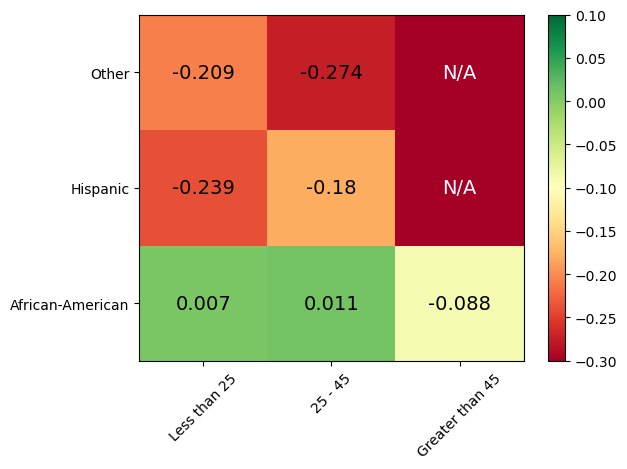

In [157]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Create the heatmap
# data[np.isclose(data, -1)] = np.nan
heatmap = ax.pcolor(data, vmin=-0.3, vmax=0.1, cmap=plt.cm.RdYlGn)

# Set the ticks in the middle of the cells
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# Set the labels for the rows and columns
ax.set_xticklabels(cols, minor=False)
ax.set_yticklabels(rows, minor=False)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a colorbar
plt.colorbar(heatmap)

for i in range(len(rows)):
    for j in range(len(cols)):
        if np.isclose(data[i,j], -1):
            ax.text(j + 0.5, i + 0.5, "N/A", size=14, ha='center', va='center', color='white')
        else:
            ax.text(j + 0.5, i + 0.5, data[i, j], size=14, ha='center', va='center', color='black')

# Show the plot
plt.tight_layout()
plt.savefig('figures/ppv_lowerbounds_heatmap.pdf')



## Test fairness

Next, we consider certifying COMPAS under the "test fairness" criteria, i.e. that its calibration error is comparable across subgroups. This claim was first made heuristically by Chouldechova et al. (2016) in relation to the African-American and Caucasian subgroups. We simultaneously bound the calibration error over all subgroups and decile scores here.

$$\epsilon(G, s) = \mathbb{P}(Y = 1 \mid S = s, X \in G) - \mathbb{P}(Y = 1 \mid S = s)$$

In [93]:
# prepare inputs to auditor

unique_races, race_inds = np.unique(df_deciles['race'].to_numpy(), return_inverse=True)
unique_ages, age_inds = np.unique(df_deciles['age_cat'].to_numpy(), return_inverse=True)
unique_sexes, sex_inds = np.unique(df_deciles['sex'].to_numpy(), return_inverse=True)

x = np.concatenate(
    (race_inds.reshape(-1,1), age_inds.reshape(-1,1), sex_inds.reshape(-1,1)), 
    axis=1
)
y = df_deciles['two_year_recid'].to_numpy()
z = df_deciles['decile_score'].to_numpy()

groups = get_intersections(x)
metric = Metric(
    name="test_fairness", 
    evaluation_function=lambda z, y: np.isclose(y, 1), 
    threshold_function=lambda z, y: np.mean(np.isclose(y, 1)), 
    metric_params={'calibration_bins' : np.unique(z)}
)

prob_threshold = (25 / len(y))

In [94]:
auditor = Auditor(x, y, z, metric)
boot_params = {'seed': 0, 'B': 500, 'student': 'prob_bound', 
               'student_threshold': prob_threshold**(3/2)}
auditor.calibrate_groups(
    alpha=0.1/len(np.unique(z)),
    type='interval',
    epsilon=None,
    groups=groups,
    bootstrap_params=boot_params
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 380.64it/s]


Below, we output a 90% confidence interval that is simultaneously valid over each $\epsilon(G, s)$. To avoid outputting hundreds of confidence intervals, we only show the intervals for the $G$ over which we are able to certify that $\max_{s} |\epsilon(G, s)| \leq 0.15$.

In [95]:
scores = np.unique(z)
for g_ind in range(groups.shape[1]):
    bound_list, metrics, thresholds = auditor.query_group(g_ind)
    if np.abs(bound_list).max() < 0.15:
        feats_filter = df_deciles[group_feats][groups[:,g_ind]].nunique() == 1
        feats_filter = feats_filter.index[feats_filter]
        group_identity = df_deciles[feats_filter][groups[:,g_ind]].drop_duplicates()
        for score, bound in zip(scores, bound_list):
            print(f"{group_identity.values[0]}-{score}: {bound}")
            print('-'*100)

['African-American']-1: [-0.05218049860518982, 0.08532643350355225]
----------------------------------------------------------------------------------------------------
['African-American']-2: [-0.10411281943253475, 0.06076656459252128]
----------------------------------------------------------------------------------------------------
['African-American']-3: [-0.054033563232977505, 0.13140556994879532]
----------------------------------------------------------------------------------------------------
['African-American']-4: [-0.05942971459961753, 0.11313221337323515]
----------------------------------------------------------------------------------------------------
['African-American']-5: [-0.08021130571737678, 0.0961454653208808]
----------------------------------------------------------------------------------------------------
['African-American']-6: [-0.09220443129749896, 0.09510176341144862]
---------------------------------------------------------------------------------------

### Boolean certification

Here we use the Boolean certification method to identify subgroups for which $\max_{s} |\epsilon(G, s)| \leq 0.15$. 

We remark that this approach fails to identify the African-American / 25-45 subgroup that the bound certification method would have found.

In [96]:
boot_params = {'seed': 0, 'B': 500, 'student': 'prob_bool', 
               'student_threshold': prob_threshold**(1/2)}
auditor.calibrate_groups(
    alpha=0.1/len(np.unique(z)), # since we now have 10 scores
    type='interval',
    epsilon=0.15,
    groups=groups,
    bootstrap_params=boot_params
)

for g_ind in range(groups.shape[1]):
    certificates, metrics, thresholds = auditor.query_group(
     groups[:,g_ind]
    )

    if np.all(certificates):
        feats_filter = df_deciles[group_feats][groups[:,g_ind]].nunique() == 1
        feats_filter = feats_filter.index[feats_filter]
        group_identity = df_deciles[feats_filter][groups[:,g_ind]].drop_duplicates()
        print(group_identity.values[0])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 350.99it/s]


['African-American']
['25 - 45']
['Male']


## Flagging disparities

### Localizing false positive rate disparities

The original COMPAS investigation of Angwin et al. (2016) flagged African-American defendants for having a higher false positive rate when compared to Caucasian ones, i.e.

$$\mathbb{P}\left(S \geq 5 \mid Y = 0, X_{\text{race}} = \text{African-American} \right) > \mathbb{P}\left(S \geq 5 \mid Y = 0, X_{\text{race}} = \text{Caucasian} \right)$$

Here we ask if we can localize this false positive rate disparity to a more granular subset of defendants. If 

$$\epsilon(G) = \mathbb{P}\left(S \geq 5 \mid Y = 0, X \in G \right) - \mathbb{P}\left(S \geq 5 \mid Y = 0\right)$$

then we flag $G$ if we can reject the null hypothesis that $\epsilon(G) \leq 0.05$. 

In [98]:
false_filter = df_deciles['two_year_recid'] == 0
df_fpr = df_deciles[false_filter]

group_feats = ['race', 'age_cat', 'sex']
unique_races, race_inds = np.unique(df_fpr['race'].to_numpy(), return_inverse=True)
unique_ages, age_inds = np.unique(df_fpr['age_cat'].to_numpy(), return_inverse=True)
unique_sexes, sex_inds = np.unique(df_fpr['sex'].to_numpy(), return_inverse=True)

x = np.concatenate(
    (race_inds.reshape(-1,1), age_inds.reshape(-1,1), sex_inds.reshape(-1,1)), 
    axis=1
)
y = df_fpr['two_year_recid'].to_numpy()
z = (df_fpr['decile_score'] >= 5).to_numpy() # high-risk flag
groups_fpr = get_intersections(x)
groups_fpr = groups_fpr[:, np.any(groups_fpr, axis=0)] # exclude groups with no values in them

metric = Metric(
    name="fpr", 
    evaluation_function=lambda z, y: np.isclose(z, 1),
    threshold_function=lambda z, y: np.mean(np.isclose(z, 1))
)

In [106]:
auditor = Auditor(x, y, z, metric)

boot_params = {'seed': 0, "student": "mad", "student_threshold": 1e-8, 
               "prob_threshold": 25 / len(x)}
flags, metric_values = auditor.flag_groups(
    groups_fpr, 
    type="lower", 
    alpha=0.1, 
    epsilon=0.05, 
    bootstrap_params=boot_params
)


for g_ind in range(groups_fpr.shape[1]):
    feats_filter = df_fpr[group_feats][groups_fpr[:,g_ind]].nunique() == 1
    feats_filter = feats_filter.index[feats_filter]
    group_identity = df_fpr[feats_filter][groups_fpr[:,g_ind]].drop_duplicates()
    if flags[g_ind]:
        print(f"{group_identity.values[0]}: {metric_values[0, g_ind]}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 935.78it/s]


['African-American']: 0.12067585280959826
['Less than 25']: 0.23186406580088142
['African-American' '25 - 45']: 0.11251147396863566
['African-American' 'Less than 25']: 0.29163370530579724
['Caucasian' 'Less than 25']: 0.18044015008001815
['African-American' 'Male']: 0.13393791828072618
['Less than 25' 'Female']: 0.3051372199191898
['Less than 25' 'Male']: 0.20638499175519695
['African-American' '25 - 45' 'Male']: 0.1351471900089206
['African-American' 'Less than 25' 'Female']: 0.3269237122939175
['African-American' 'Less than 25' 'Male']: 0.27957256367694605
['Caucasian' 'Less than 25' 'Female']: 0.39729408266428784
['Hispanic' 'Less than 25' 'Male']: 0.24077234353385307


### Localizing PPV disparities

The rebuttal from Northpointe claimed that COMPAS was fair if measured by PPV. Here, we see if it is possible to discover any positive predictive value disparities. Define

$$\epsilon(G) = \mathbb{P}\left(Y = 1 \mid S \geq 5, X \in G \right) - \mathbb{P}\left(Y = 1 \mid S \geq 5\right)$$

then we flag $G$ if we can reject the null hypothesis that $\epsilon(G) \geq -0.05$. 

In [122]:
# filter by binary prediction
angwin_threshold = 5
northpointe_threshold = 8
high_risk_filter = df_deciles['decile_score'] >= angwin_threshold
df_ppv = df_deciles[high_risk_filter] # filter to just high-risk offenders

# inputs to auditor are constructed below
unique_races, race_inds = np.unique(df_ppv['race'].to_numpy(), return_inverse=True)
unique_ages, age_inds = np.unique(df_ppv['age_cat'].to_numpy(), return_inverse=True)
unique_sexes, sex_inds = np.unique(df_ppv['sex'].to_numpy(), return_inverse=True)

x = np.concatenate(
    (race_inds.reshape(-1,1), age_inds.reshape(-1,1), sex_inds.reshape(-1,1)), 
    axis=1
)
y = df_ppv['two_year_recid'].to_numpy()
z = races_ppv[:,2] # white indicators
groups_ppv = get_intersections(x)

metric = Metric(
    name="PPV_Average", 
    evaluation_function=lambda z, y : np.isclose(y, 1), 
    threshold_function=lambda z, y: np.mean(np.isclose(y, 1))
)

In [125]:
auditor = Auditor(x, y, z, metric)
boot_params = {'seed': 0, "student": "mad", "student_threshold": 1e-8,
               "prob_threshold": 25 / len(x)}
flags, metric_values = auditor.flag_groups(
    groups_ppv, 
    type="upper", 
    alpha=0.1, 
    epsilon=-0.05, 
    bootstrap_params=boot_params
)

for group_ind in range(groups_ppv.shape[1]):
    if flags[group_ind]:
        feats_filter = df_ppv[group_feats][groups_ppv[:,group_ind]].nunique() == 1
        feats_filter = feats_filter.index[feats_filter]
        group_identity = df_ppv[feats_filter][groups_ppv[:,group_ind]].drop_duplicates()
        print(f"{group_identity.values[0]}: {metric_values[0, group_ind]}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 954.15it/s]

['Female']: -0.11314602176748438
['Less than 25' 'Female']: -0.18683897200147062
['Caucasian' 'Less than 25' 'Female']: -0.2439878321758597
